In [12]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm # tqdm is a package that lets you make progress bars to see how a loop is going
import os 
import glob # this package lets you search for filenames
import pandas as pd # pandas is a popular library in industry for manipulating large data tables
from astropy.timeseries import LombScargle
import warnings
warnings.filterwarnings('ignore')

mpl.style.use('seaborn-colorblind') # colourblind-friendly colour scheme
# subsequent lines default plot settings
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['figure.figsize']=(8.0,6.0)   
mpl.rcParams['font.size']=16              
mpl.rcParams['savefig.dpi']= 300             

In [13]:
ddir_stars = 'C:/Users/emily/Documents/University/ThirdYear/FebuarySem/Astronomy/CosmicDistanceLadder/universe_8' # point this to where you unzip your data!

ddir = ddir_stars + '/Variable_Star_Data/'

fnames = glob.glob(ddir+'*.csv')

freqs = np.linspace(1/100,0.45,10000) # choose your grid so that it doesn't go higher than Nyquist limit
periods = [] # start an empty list to hold the period 
names = []

for fname in tqdm(fnames): # tqdm is a package that gives you a progress bar - neat! 
    data = pd.read_csv(fname) # load in CSV data as a Pandas object

    time, flux = data.Time, data.NormalisedFlux # just extract the columns as variables

    LS = LombScargle(time,flux) # initialize a Lomb-Scargle
    power = LS.power(freqs) # calculate LS power 
    bestfreq = freqs[np.argmax(power)] # which frequency has the highest Lomb-Scargle power?
    
    pred = LS.model(time,bestfreq) # make a sine wave prediction at the best frequency
    
    periods.append(1/bestfreq) # add each period to the list
    names.append(os.path.basename(fname).strip('.csv')) # os.path.basename gets rid of directories and gives you the filename; then we strip '.csv'

periods = np.array(periods) # turn it from a list to an array
names = np.array(names) # turn it from a list to an array

variables = pd.DataFrame({'Name':names,
              'Period':periods}) # turn two arrays into a dataframe

  0%|          | 0/3360 [00:00<?, ?it/s]

100%|██████████| 3360/3360 [00:37<00:00, 88.72it/s] 


In [14]:
allStars=pd.read_csv(ddir_stars+'/AllStars.csv', index_col="Name")

closeStars=allStars.query('Parallax > 0.01')  # 10 mas parallax cut
print(len(closeStars), "Stars with good parallax") # check how many stars there are total with good parallax

800 Stars with good parallax


In [15]:
closeVariables=pd.merge(closeStars, variables, on='Name')
# merge these two arrays according to the keyword 'name'

print('Of which',len(closeVariables),'variables')


Of which 37 variables


Text(0, 0.5, 'Luminosity')

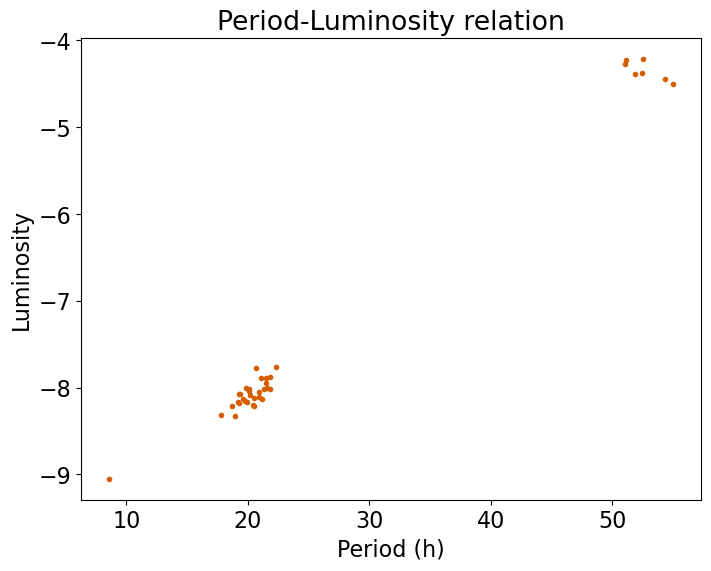

In [16]:
v0, v1, v2 = np.log10(closeVariables['BlueF']), np.log10(closeVariables['GreenF']), np.log10(closeVariables['RedF']) 
variable_colour = v2-v0
luminosity = v1 + 2*np.log10(1./closeVariables.Parallax)

closeVariables['Luminosity']=luminosity
fig=plt.figure()
plt.plot(closeVariables.Period,closeVariables.Luminosity,'.',color='C2')
plt.title("Period-Luminosity relation")
plt.xlabel('Period (h)')
plt.ylabel('Luminosity')


In [24]:

variableslong=closeVariables.query('Period > 45')
#variableslong=variableslong.reset_index()

variablesshort=closeVariables.query('Period > 15 and Period < 25')
#variablesshort=variablesshort.reset_index()


Long Gradient: -0.05827881002086881 Long Intercept: -1.2804111391701847


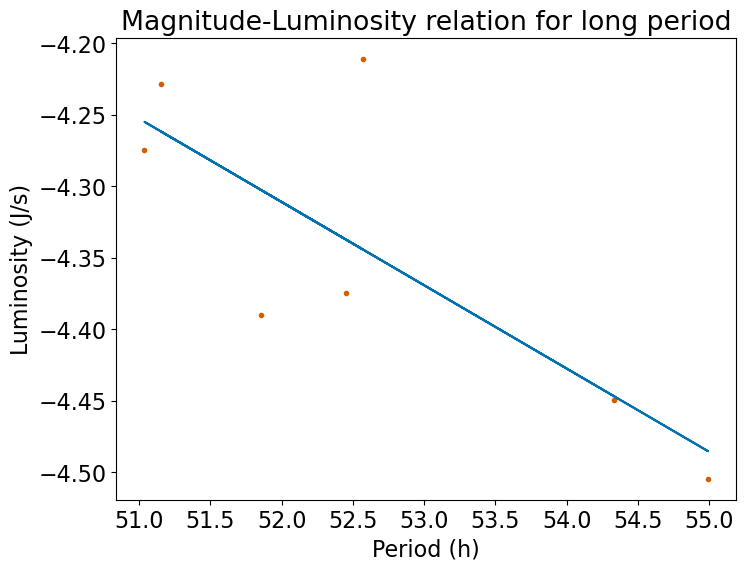

In [25]:

periodLongList=np.array(variableslong.Period)
LumLongList=np.array(variableslong.Luminosity)

C = np.vander(periodLongList,2) # the Vandermonde matrix of order N is the matrix of polynomials of an input vector 1, x, x**2, etc
d, residuals, rank, s = np.linalg.lstsq(C,LumLongList)
mlong=d[0]
intlong=d[1]

reconstructed2 = C @ d


fig=plt.figure()
plt.plot(variableslong.Period,variableslong.Luminosity,'.',color='C2')
plt.plot(variableslong.Period,(mlong*variableslong.Period)+intlong)
plt.title("Magnitude-Luminosity relation for long period")
plt.xlabel('Period (h)')
plt.ylabel('Luminosity (J/s)')
print("Long Gradient:", mlong, "Long Intercept:", intlong)


Short Gradient: 0.09491154706483619 Short Intercept: -10.00135125632899


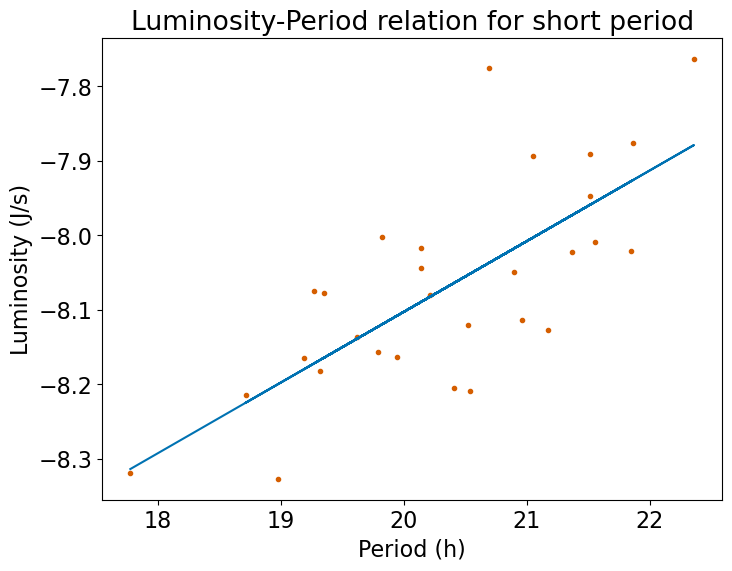

In [26]:

periodShortList=np.array(variablesshort.Period)
LumShortList=np.array(variablesshort.Luminosity)
A = np.vander(periodShortList,2) # the Vandermonde matrix of order N is the matrix of polynomials of an input vector 1, x, x**2, etc
b, residuals, rank, s = np.linalg.lstsq(A,LumShortList)
reconstructed1 = A @ b
mshort=b[0]
intshort=b[1]

fig=plt.figure()
plt.plot(variablesshort.Period,variablesshort.Luminosity,'.',color='C2')
plt.plot(variablesshort.Period,(mshort*variablesshort.Period)+intshort)
plt.title("Luminosity-Period relation for short period")
plt.xlabel('Period (h)')
plt.ylabel('Luminosity (J/s)')
print("Short Gradient:", mshort, "Short Intercept:", intshort)

In [39]:
allVariables=pd.merge(allStars, variables, on='Name')
allVariableslong=allVariables.query('Period > 45')
allVariableslong['Luminosity']= (allVariableslong['Period']*mlong)+intlong
#allVariableslong['Distance']=np.power(10,(allVariableslong['Luminosity']-(np.log10(allVariableslong['GreenF'])))/2)

allVariables=pd.merge(allStars, variables, on='Name')
allVariablesshort=allVariables.query('Period > 15 and Period < 25')
allVariablesshort['Luminosity']= (allVariablesshort['Period']*mshort)+intshort
#allVariablesshort['Distance']=np.power(10,(allVariablesshort['Luminosity']-(np.log10(allVariablesshort['GreenF'])))/2)

finalVariables=pd.concat([allVariableslong,allVariablesshort])
finalVariables['Distance']=np.power(10,(finalVariables['Luminosity']-(np.log10(finalVariables['GreenF'])))/2)

farVariables=finalVariables.query('Distance > 8000')

#plt.plot(allVariableslong.Distance, allVariableslong.Luminosity, color='red', marker='o', linestyle='none', markersize=1)
#plt.plot(allVariablesshort.Distance, allVariablesshort.Luminosity, color='green', marker='o', linestyle='none', markersize=1)
#plt.xlabel('Distance')
#plt.ylabel('Absolute Magnitude')
#plt.show()

#finalVariables.to_csv('Mag.csv', index=False)
farVariables.to_csv('Far.csv', index=False)